In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import pandas as pd
from torch import optim
import re
import json
import cv2
import types

from utils import *

In [2]:
import fastai
fastai.__version__

'1.0.40.dev0'

I am using a very simple library I started to work on to create the datasets. You can find it (along with installation instructions) [here](https://github.com/radekosmulski/zen_dataset).

Right now it does next to nothing, but maybe I will keep adding to it. The fastai library does a lot of things and sometimes I just want to point some code at a folder and run a model on the data. The couple of lines of code in the repository I linked to above allows me to do that.

In [3]:
from zen_dataset import *
from zen_dataset.utils import *

In [4]:
class Reader():
    def __init__(self, path):
        self.path = path
    def __call__(self, item):
        image_path = f'{self.path}/{item}'
        image = open_image(image_path)
        tensor = image2tensor(image)
        return imagenet_normalize(tensor)

All the code below does is create two Datasets. Each Dataset has an attribute items (`train_ds.items`) which stores a collection of paths. When a Dataset is asked to return a piece of data to be used for training / inference, it will hand the item over (a single path) to the Reader and the labeler. Here there Reader will read the image file from disk and return a tensor.

Since we don't care about the labels, the labeler will always return a 0.

In [5]:
train_ds = Dataset(pd.read_csv('data/train.csv').Image, Reader('data/train-224'), lambda item: 0)

fns = [p.name for p in paths_to_files_in('data/test-224')]
test_ds = Dataset(fns, Reader('data/test-224'), lambda item: 0)

Below we are creating two DataLoaders. A DataLoader wraps a Dataset and batches the data. It does so in parallel (hence we can specify the number of workers). Here you have full control over creating the DataLoaders - you could change the Sampler, BatchSampler, specify whether the data should be shuffled, etc.

For instance, we are not shuffling the train set.

The one useful piece of information here is that what a DataLoader will do is index into the train and test datasets like this:

```train_ds[idx]```

This is useful to be aware of this, because all the Dataset will do at this point is return a tuple of `(image_tensor, 0)`. The Dataloader will then collate the returned data into a batch, which will be a list of two tensors: 

`(image_tensors, labels)`

Since we know the dimension of our images, we know that image_tensors will have a shape of `(BS, 3, 224, 244)` and labels of `(BS,)`


In [6]:
NUM_WORKERS = 12
BS = 64

train_dl = DataLoader(train_ds, batch_size=BS, num_workers=NUM_WORKERS)
test_dl = DataLoader(test_ds, batch_size=BS, num_workers=NUM_WORKERS)

Let's confirm the dimensionality of batched data:

In [7]:
batch = next(iter(train_dl))
type(batch)

list

In [8]:
batch[0].shape, batch[1].shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

Knowing this about the Dataset / DataLoader API is useful because it allows us to construct very interesting things from simple elements.

For instance, in this competition there seems to be some sort of a leak related to image size. Maybe also the exif information could be used. One could construct a Dataset that returns a tuple of information like this:

`(image_tensor, [image_width, image_height], [some_exif_fields_maybe_used_with_embeddings], label)`

You probably want to normalize image dimensions somehow. All that would then need to be done is creating a model that in its forward method accepts the three pieces of data.

I did something along these lines for the quickdraw competition and you can find the notebook [here](https://github.com/radekosmulski/quickdraw/blob/master/cnn_rnn_countrycodes.ipynb).

I find such multi modality models very interesting and capable. A model combining embeddings and image data gave me a 5th place in this [competition](https://www.kaggle.com/c/google-ai-open-images-visual-relationship-track) and I trained it on next to no hardware (a single GPU).

I have not used keras in ages but I don't think current tools make it super easy to explore such models. Hopefully maybe I am missing something or the situation will change relatively soon. Anyhow, with the information above and the `zen_dataset` approach creating a custom Dataset should be quite straightforward (that is assuming one can figure out how to set up the labeler). 

Below we create a `fastai` `DataBunch`. It is really great that we can be up to all these shenanigans with creating datasets and then we use the DataBunch as an entry way into the `fastai` world and `fastai` picks up seamlessly from there.

In [9]:
data = DataBunch(train_dl, test_dl)

In [10]:
class FlukeDetector(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)

In [11]:
def loss_fn(preds, targs, class_idxs): return L1Loss()(preds, targs.squeeze())
learn = Learner(data, FlukeDetector(arch=models.resnet50), loss_func=loss_fn)
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [12]:
state_dict = torch.load('data/train-224/models/fluke_detector.pth')
learn.model.load_state_dict(state_dict['model'])

In [13]:
train_preds, _ = learn.get_preds(DatasetType.Train)
test_preds, _ = learn.get_preds(DatasetType.Valid)

In [14]:
def extract_bbox(fn, scaled_coords, directory='train'):
    im = open_image(f'data/{directory}/{fn}')
    width, heigth = im.size
    ary = np.asarray(im)
    y_up_left, x_up_left, y_low_right, x_low_right = ((scaled_coords + 1)  / 2).clamp(0,1).numpy()
    y_up_left = np.round(y_up_left * heigth)
    x_up_left = np.round(x_up_left * width)

    y_low_right = np.round(y_low_right * heigth)
    x_low_right = np.round(x_low_right * width)

    y_up_left, x_up_left, y_low_right, x_low_right = list(map(int, [y_up_left, x_up_left, y_low_right, x_low_right]))
    return ary[y_up_left:y_low_right, x_up_left:x_low_right]

In [15]:
!rm -rf data/train-extracted-224
!rm -rf data/test-extracted-224

!mkdir data/train-extracted-224
!mkdir data/test-extracted-224

In [16]:
%%time

SZ = 224
for i, fn in enumerate(train_ds.items):
    ary = extract_bbox(fn, train_preds[i])
    if 0 in ary.shape:
        print(f'{fn} - failed to extract bbox')
        continue
    im = PIL.Image.fromarray(ary)
    im = im.resize((SZ, SZ), resample=PIL.Image.BICUBIC)
    im.save(f'data/train-extracted-{SZ}/{fn}')

85a95e7a8.jpg - failed to extract bbox
b370e1339.jpg - failed to extract bbox
b4cb30afd.jpg - failed to extract bbox
d4cb9d6e4.jpg - failed to extract bbox
CPU times: user 5min 3s, sys: 2.45 s, total: 5min 5s
Wall time: 5min 5s


In [17]:
ims = []
for fn in ['85a95e7a8.jpg', 'b370e1339.jpg', 'b4cb30afd.jpg', 'd4cb9d6e4.jpg']:
    ims.append(np.asarray(open_image(f'data/train-224/{fn}')))

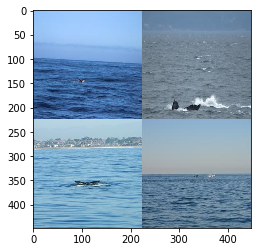

In [18]:
plt.imshow(montage(np.stack(ims), multichannel=True))

In [19]:
%%time

SZ = 224
for i, fn in enumerate(test_ds.items):
    ary = extract_bbox(fn, test_preds[i], 'test')
    if 0 in ary.shape:
        print(f'{fn} - failed to extract bbox')
        continue
    im = PIL.Image.fromarray(ary)
    im = im.resize((SZ, SZ), resample=PIL.Image.BICUBIC)
    im.save(f'data/test-extracted-{SZ}/{fn}')

6a72d84ca.jpg - failed to extract bbox
CPU times: user 1min 34s, sys: 756 ms, total: 1min 35s
Wall time: 1min 35s


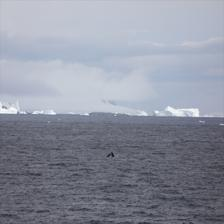

In [20]:
open_image('data/test-224/6a72d84ca.jpg')

The images where bbox extraction failed will need to be removed from the train and test sets. Probably it is safe to predict the 'new_whale' class for that single image above in the test set.

Let's take a look at the extracted images.

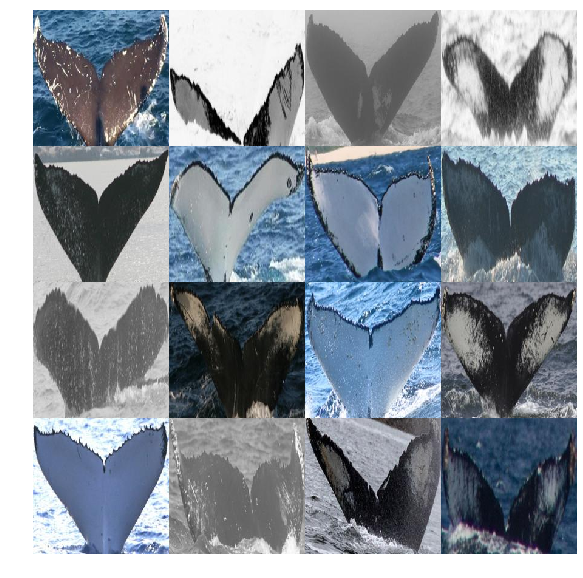

In [21]:
paths = paths_to_files_in('data/train-extracted-224/')
np.random.shuffle(paths)

ims = []
for path in paths[:16]: ims.append(np.asarray(open_image(path)))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

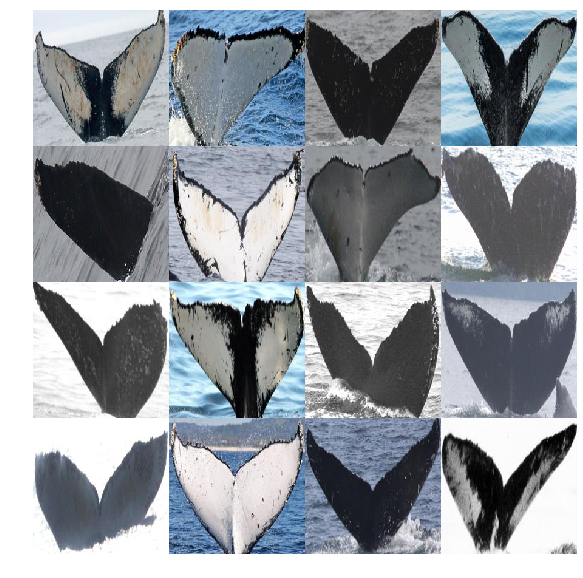

In [22]:
paths = paths_to_files_in('data/test-extracted-224/')
np.random.shuffle(paths)

ims = []
for path in paths[:16]: ims.append(np.asarray(open_image(path)))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))

The fluke occupies a much larger effective area than in the original images. This should help with any form of training one might do. Also, the flukes are extracted from full size images, so not only do they occupy a greater area in the image but they should also contain more information.

There is also some spatial alignment going on. To get better results on this other techniques should be used but I suspect even what we have here should be helpful.

Below I extract bounding boxes to 448x448 images.

In [26]:
SZ = 448

!rm -rf data/train-extracted-{SZ}
!rm -rf data/test-extracted-{SZ}

!mkdir data/train-extracted-{SZ}
!mkdir data/test-extracted-{SZ}

In [27]:
%%time

for i, fn in enumerate(train_ds.items):
    ary = extract_bbox(fn, train_preds[i])
    if 0 in ary.shape:
        print(f'{fn} - failed to extract bbox')
        continue
    im = PIL.Image.fromarray(ary)
    im = im.resize((SZ, SZ), resample=PIL.Image.BICUBIC)
    im.save(f'data/train-extracted-{SZ}/{fn}')

85a95e7a8.jpg - failed to extract bbox
b370e1339.jpg - failed to extract bbox
b4cb30afd.jpg - failed to extract bbox
d4cb9d6e4.jpg - failed to extract bbox
CPU times: user 5min 51s, sys: 3.55 s, total: 5min 54s
Wall time: 5min 56s


In [28]:
%%time

for i, fn in enumerate(test_ds.items):
    ary = extract_bbox(fn, test_preds[i], 'test')
    if 0 in ary.shape:
        print(f'{fn} - failed to extract bbox')
        continue
    im = PIL.Image.fromarray(ary)
    im = im.resize((SZ, SZ), resample=PIL.Image.BICUBIC)
    im.save(f'data/test-extracted-{SZ}/{fn}')

6a72d84ca.jpg - failed to extract bbox
CPU times: user 1min 51s, sys: 1.06 s, total: 1min 52s
Wall time: 1min 53s
